# Meteo 515 – Assignment 2 – Parametric Distributions
*Part 1 – Fitting dists to annual mean & max State College weather station data*

In [1]:
from __future__ import division, print_function
#import datetime as dt

from colorama import init, Fore
#init(autoreset=True)  # using init somehow turns off color output in the Spyder IPython console...
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as ss
#from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm

In [2]:
plt.style.use('seaborn-darkgrid')
%matplotlib notebook

## Load the data

In [3]:
convert_dateint = lambda d: pd.to_datetime(str(d))

df = pd.read_excel('./data/SC_data.xlsx',
    header=None, 
    names=['date', 'Tmax', 'Tmin', 'PCP', '5', '6'],
    converters={0: convert_dateint},
    )
df.set_index('date', inplace=True)

## Some data cleanup
We replace the missing value tag with value `np.nan` and show the fraction of the data that is missing for each variable. We could also remove 2017 from the dataset, because 2017-11-20 is the last day, but since other years (especially for precip) have comparable missing fraction, I do not do that here. Especially with the low level of precision that we have in the data, the influence of the missing days on the 2017 mean and max is probably not significant. 

In [4]:
#> missing values
varnames = ['Tmax', 'Tmin', 'PCP']

#for varname in varnames:  # probably can do without loop
#    df.loc[df[varname] == -99.0, varname] = np.nan  # the missing value tag is -99
df.replace(-99.0, np.nan, inplace=True)  # does the same as above loop

df.loc[df.PCP < 0, 'PCP'] = np.nan  # trace precip has the value -1 in the dataset. with this indexing we avoid the SettingWithCopyWarning 

df_dropna = df.dropna()  # this drops entire rows that have any nans in them...

In [5]:
data = {}  # here drop nans from columns individually
for varname in varnames:
    data[varname] = df[varname].dropna()  # gives SettingWithCopyWarning?
#    data[varname] = df.loc[:,varname].dropna()  # apparently this is the preferred method?: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
#    data[varname].dropna(inplace=True)          # though maybe should also do .dropna(inplace=True) in a separate line. because this method still gives the warning, but only the first time it is run

#> analyze missing/trace data fraction
#print('NaN counts:')
#print(df.isna().apply(np.count_nonzero))
fmt = '  {c1:s}{{:>8s}}: {c2:s}{{:.2g}}'.format(c1=Fore.GREEN, c2=Fore.BLUE)
print('\nMissing data fraction:')
for k, v in data.items():
    print(fmt.format(k, 1-v.size/df.shape[0]))
print(fmt.format('any var', 1-df_dropna.size/df.size))

#> omit 2017?? to be fair in the annual means and such
#  but we do have all the way to Nov 20th, so think will leave it in...


Missing data fraction:
      Tmax: 0.00042
      Tmin: 0.0019
       PCP: 0.18
   any var: 0.19


## Plot time series for sanity check

<IPython.core.display.Javascript object>


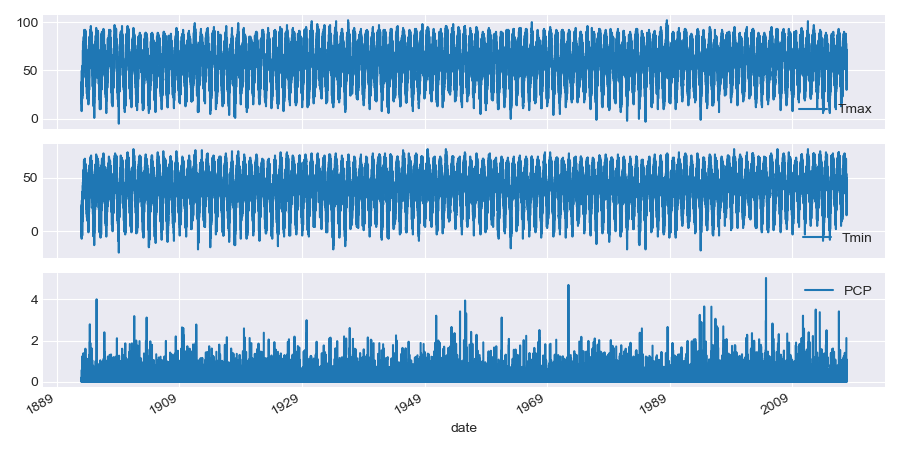

In [6]:
f0, aa = plt.subplots(3, 1, figsize=(9, 4.5), sharex=True, num='ts')

for i, k in enumerate(varnames):
    df.plot(y=k, ax=aa.flat[i])  # this df has the raw data, but with missing values marked with nan
    
f0.tight_layout();  # semicolon to suppress console output from this plotting cell

## a) Gaussian fits to annual average Tmax and PCP

<IPython.core.display.Javascript object>


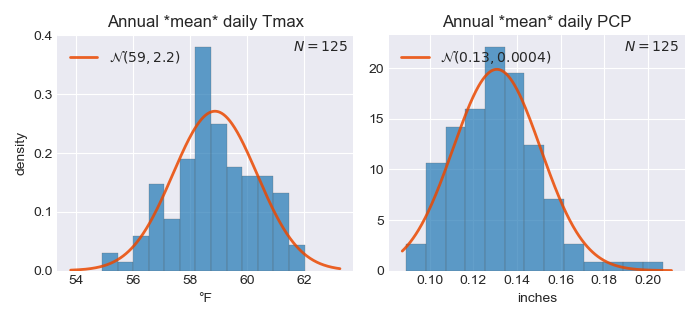

In [7]:
#> compute annual averages
#df_annual_means = df.groupby(df.index.dt.year).transform('mean')  # does not reduce row number
df_annual_means = df.groupby(pd.Grouper(freq='A')).mean()  # DataFrame.mean skips nans by default; but if we needed something else, can use df.apply(fn)

deg_symbol = u'\u00B0'
pdf_color = '#ea4800'

f1, aa = plt.subplots(1, 2, figsize=(7, 3.2), num='annual_mean')

names = ['Tmax', 'PCP']
for i, name in enumerate(names):
    
    ax = aa[i]
    ds = df_annual_means[name]
    
    xplot = np.linspace(ds.min()*0.98, ds.max()*1.02, 400)
    
    ax.hist(ds, bins=13, density=True, alpha=0.7, ec='0.35', lw=0.25, label=None)
    
    xbar = ds.mean()
    s = ds.std()
    ax.plot(xplot, ss.norm.pdf(xplot, xbar, s), '-', c=pdf_color, alpha=0.85, lw=2, 
            label='$\mathcal{{N}}({:.2g}, {:.2g})$'.format(xbar, s**2))
    
    ax.set_title('Annual *mean* daily '+name)
    ax.text(0.98, 0.98, '$N={:d}$'.format(ds.size), va='top', ha='right', transform=ax.transAxes)
    
    ax.legend(loc='upper left')

aa[0].set_xlabel(deg_symbol+'F')
aa[0].set_ylabel('density')
aa[1].set_xlabel('inches')

f1.tight_layout();

### Discussion:

From the histograms, the distribution of annual means of daily Tmax in State College, PA seems slightly skewed left (just as when looking at the boxplots of all of the daily data in hw1). PCP is still skewed right, but not nearly as dramatically as in the case of the daily data. We expect the means of subsamples should be normally distributed, and the Gaussian fits do indeed seem to match pretty well with the histograms.

## b) Gumbel fits to annual maximum Tmax and PCP

In [8]:
def myGumbel_pdf(x, loc=0, scale=1):
    """Calculate pdf for Gumbel dist at x
    loc:   location/shift param zeta
    scale: scale param beta
    """
    return 1/scale * np.exp( -np.exp(-(x-loc)/scale) - (x-loc)/scale)

<IPython.core.display.Javascript object>


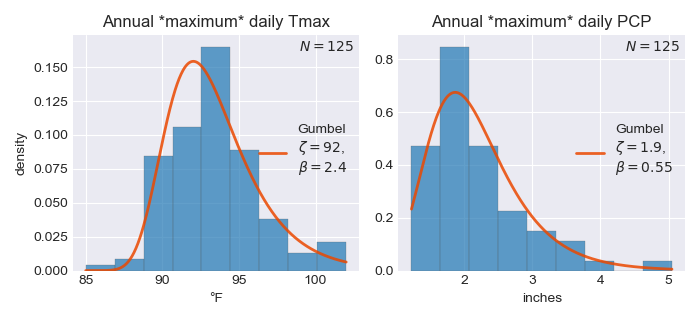

In [9]:
df_annual_maxs = df.groupby(pd.Grouper(freq='A')).max()

f2, aa = plt.subplots(1, 2, figsize=(7, 3.2), num='annual_max')

names = ['Tmax', 'PCP']
for i, name in enumerate(names):
    
    ax = aa[i]
    ds = df_annual_maxs[name]
    
    xplot = np.linspace(ds.min(), ds.max(), 400)
    
    ax.hist(ds, bins=9, density=True, alpha=0.7, ec='0.35', lw=0.25, label=None)
    
    xbar = ds.mean()
    s = ds.std()
    beta_hat = s*np.sqrt(6)/np.pi
    zeta_hat = xbar - np.euler_gamma*beta_hat
    ssfit = ss.gumbel_r.pdf(xplot, loc=zeta_hat, scale=beta_hat)
    myfit = myGumbel_pdf(xplot, loc=zeta_hat, scale=beta_hat)
    assert( np.allclose(ssfit, myfit) )  # note: our Gumbel formula gives same results as gumbel_r, not gumbel_l...
    
    s = 'Gumbel\n$\zeta = {:.2g}$,\n' + r'$\beta = {:.2g}$'
    ax.plot(xplot, myfit, '-', c=pdf_color, alpha=0.85, lw=2, 
            label=s.format(zeta_hat, beta_hat))
#    ax.plot(xplot, myfit, '-', c='g', alpha=0.85, lw=2, label='my Gumbel')
    
    ax.set_title('Annual *maximum* daily '+name)
    ax.text(0.98, 0.98, '$N={:d}$'.format(ds.size), va='top', ha='right', transform=ax.transAxes)    

    ax.legend(loc='center right')

aa[0].set_xlabel(deg_symbol+'F')
aa[0].set_ylabel('density')
aa[1].set_xlabel('inches')

f2.tight_layout();

### Discussion:

Since the temperatures in the dataset are only whole numbers, the histogram for annual maximum daily Tmax ends up looking somewhat jagged with smaller binwidth. However, with larger bins, the Gumbel distribution matches up quite well with both annual maximum daily Tmax and PCP. Compared to Tmax, for PCP the ratio of the scale parameter to loc parameter is much larger. A larger $N$ combined with smaller binwidths would give us a nicer visualization. 

## c) Q-Q plots for Gumbel fits to annual maximum Tmax and PCP

Supposedly `qqplot` from StatsModels has the ability to pass loc and scale parameters to the theoretical distribution, but this was not working no matter what I tried. And normalizing the sample instead using `fit=True` isn't really what we want.

<IPython.core.display.Javascript object>


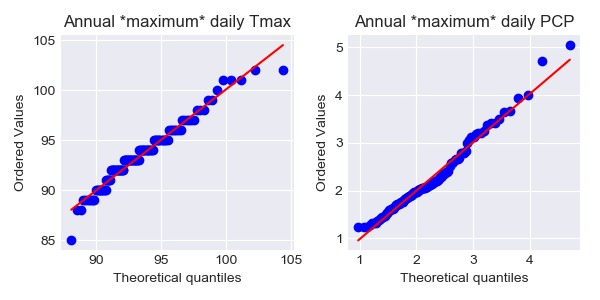

In [10]:
f3, aa = plt.subplots(1, 2, figsize=(6, 3), num='annual_max_q-q_gumbel')

names = ['Tmax', 'PCP']
for i, name in enumerate(names):
    
    ax = aa[i]
    ds = df_annual_maxs[name]
    
    xbar = ds.mean()  # these are calculated in b) as well. could have saved them..
    s = ds.std()
    beta_hat = s*np.sqrt(6)/np.pi
    zeta_hat = xbar - np.euler_gamma*beta_hat
    rv = ss.gumbel_r(loc=zeta_hat, scale=beta_hat)

    ss.probplot(ds, dist=rv, plot=ax)  # the "probability plot" is not necessarily the same as a Q-Q plot. though in this case it seems it gives the same plot...
    
    #sm.qqplot(ds, dist=ss.gumbel_r, line='r', 
           #fit=False, loc=zeta_hat, scale=beta_hat,  # If fit is false, loc, scale, and distargs are passed to the distribution. But this seems to be failing...
           #fit=True,  # instead of passing loc and scale, `fit=True` normalizes the sample data 
           #ax=ax)
    
    ax.set_title('Annual *maximum* daily '+name)
    
f3.tight_layout();

### Discussion:

The Gumbel fit quantiles and data quantiles, when plotted against each another, fall nearly on a straight line, indicating that the fit is good. However, we see that at the edges, we see some deviations from the 1:1 line in both cases. For example, for PCP, at low values, the fitted Gumbel has PCP propability decreasing more quickly as we move leftward to smaller values than the observed, i.e., the left tail is too small. 

## Save figures locally
Probably a silly thing for a Jupyter Notebook to do but whatever

In [11]:
%%javascript
var kernel = IPython.notebook.kernel;  // https://stackoverflow.com/a/23619544
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebookName = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [12]:
#> save figs; requires that the 'figs' dir exists..
for n in plt.get_fignums():
    f = plt.figure(n)
    f.savefig('./figs/{:s}_{:s}.pdf'.format(theNotebookName, f.get_label()), 
        transparent=False, 
        bbox_inches='tight', pad_inches=0.05,
        )

NameError: name 'theNotebookName' is not defined